# Ising Model

This is a 'sandbox', feel free to modify

Galen Wilkerson


Based on model by Uri Wilensky:

http://ccl.northwestern.edu/netlogo/models/Ising

# Setup and Functions

In [4]:
# install graph drawing and interaction libraries
# !pip uninstall networkx -y
# !pip install networkx==1.11

# !pip install nxpd
# !pip install ipywidgets
# !apt-get install python-pydot

import pandas as pd
import numpy as np
import math

import sympy 
from sympy import *
from sympy import Matrix
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Function

import networkx as nx

import __future__
import __init__

%matplotlib inline

import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Latex

#If you want all graphs to be drawn inline, then you can set a global parameter.
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

import string

from ipywidgets import Image
#from IPython import display

from ipywidgets import interact
import ipywidgets as widgets

from IPython.display import Math, HTML, display

In [296]:
class IsingModel2D():
    
    def __init__(self, height = 10, width = 10, randomize = True, temperature = 5, p = .5):
        '''
        initialize lattice and connections, store in networkx grid_2d_graph
        '''
        
        self.height = height
        self.width = width
        
        # the temperature is in [0,10]
        self.temperature = temperature
        
        # the graph of connections
        self.G = nx.grid_2d_graph(height, width)
        
        # the lattice of spins
        value_dict = self.randomize(height, width, p)
        nx.set_node_attributes(self.G, value_dict, 'spin')

        # find the sum of spins and magnetization 
        self.magnetization()
        
        # set the node positions for drawing
        self.position = {}
        for i in range(height):
            for j in range(width):
                self.position[i,j] = (i/height,j/width)

        nx.set_node_attributes(self.G, self.position, 'pos')

        nx.set_node_attributes(self.G, 1, 'size')
        nx.set_node_attributes(self.G, 'white', 'nodecolor')

        
    def randomize(self, height = 10, width = 10, p = .5):
        '''
        create random lattice spins
        
        inputs: height, width of lattice
                p = probabilty of spin +1
                
        returns: dictionary of nodeids, spin values (strings)
                 sets self.sum_spins = sum of spin values
        '''

        # create random spin values
        spins = [+1, -1]
        spin_lattice = np.random.choice(a = spins, size = [height,width], p=[p, 1-p]) 
                
        # store the spin values in the graph        
        value_dict = {}
        
        for i in range(spin_lattice.shape[0]):
            for j in range(spin_lattice.shape[1]):
                value_dict[(i,j)] = spin_lattice[i,j] 
            
        return(value_dict)
        
            
    def print_graph(self):
        '''
        print the lattice as a (height, width) box of spins
        '''
        
        print(np.reshape(list(nx.get_node_attributes(ising.G, 'spin').values()), 
                         newshape = [self.height, self.width]))

        
    def draw_graph(self, title = "Lattice"):
        '''
        draw the graph of spins with lattice connections
        '''
        
        
        # create empty list for node colors
        node_color = []

        # for each node in the graph
        for node in self.G.nodes(data=True):

            # if the node has the attribute group1
            if node[1]['spin'] == -1:
                node_color.append('blue')

            # if the node has the attribute group1
            else:
                node_color.append('red')

        
        
        nx.draw(self.G, 
                self.position, 
                node_color=node_color, 
                edge_color='grey', 
                alpha=.3)#, 
                #node_size=20)
        
        # draw graph with node attribute color
        #nx.draw(g, with_labels=False, node_size=25, node_color=node_color)

        labels = nx.get_node_attributes(self.G, 'spin')
        pos = nx.get_node_attributes(self.G, 'pos')
        nx.draw_networkx_labels(self.G, pos=pos, labels=labels)
        plt.title(title)
        
        plt.gca().set_aspect('equal', adjustable='box')
        
        

    def draw_graphviz(self):
        '''
        draw graph using graphviz instead of matplotlib
        
        see nxpd documentation
        '''
        
        # draw networkx graph with graphviz
        im = draw(self.G)
        im
    
    
    def animate(self, height = 10, width = 10):
        
        # simple animation of changing spin bias

        def updateAnimation(p = (0.01,1.00)):
            # draw networkx graph with graphviz

            self = IsingModel2D(height, width, p = p)
            title = 'magnetization ' + str(self.magnetization())
            self.draw_graph(title)

        interact(updateAnimation);
    
    
    def get_spin(self, i,j):
        '''
        get spin at i, j
        '''
        
        return nx.get_node_attributes(self.G, 'spin')[(i,j)]
    
    
    def get_neighbor_spins(self, i,j):
        '''
        get the spin values of neighbors of node i,j
        '''
        
        n = self.G.neighbors(n=(i,j))
        
        results = []
        for i1 in n:
            results.append((self.get_spin(i1[0], i1[1])))
        
        return(results)
    
    
    def get_ediff(self, i, j):
        '''
        calculate difference between spin at a node and spin of neighbors

        ediff = 2 * my_spin * sum(spin_neighbors)

        inputs: 
            coordinates of node
        
        returns:
            ediff value for this coordinate
            set self this graph node's ediff value
            
    
        TODO:
        edge case?
        vectorize?

        '''
        
        spin = self.get_spin(i,j)
        spin_neighbors = self.get_neighbor_spins(i,j)
        
        
        ediff = 2 * spin * np.sum(spin_neighbors)

        self.G.node[i,j]['ediff'] = ediff
    
        return (ediff)
    
    
    def magnetization(self):
        '''
        returns the average magnetization: sum of spins (magnetization) / lattice size
        
        for now, just use Juri Wilensky's magnetization nelogo model calculation
        '''
        
        spins = np.array(list(nx.get_node_attributes(self.G, 'spin').values()))
        self.sum_spins = spins.astype(int).sum()    
        #print(self.sum_spins)
        
        return(self.sum_spins / (self.height * self.width))
    
    
        
    def update(self, temperature = 0):
        '''
        update each node's flip based on temperature and neighbor values
        
         if (Ediff <= 0) or (temperature > 0 and (random-float 1.0 < exp ((- Ediff) / temperature))) [
        set spin (- spin)
        set sum-of-spins sum-of-spins + 2 * spin
        '''
        
        self.magnetization()
        self.temperature = temperature
        
        for i in range(self.height):
            for j in range(self.width):
                
                ediff = self.get_ediff(i,j)
                p = np.e ** (- ediff / self.temperature)
                randnum = np.random.rand()
                
                if ((ediff <= 0) or (self.temperature > 0 and randnum < p)):
                    spin = self.G.node[i,j]['spin']
                    self.G.node[i,j]['spin'] *= -1
                    #self.sum_spins = self.sum_spins + 2 * spin
        
        

    def runIsing(self):
        '''
        update the ising model flips based on the temperature
        '''
        
        self = IsingModel2D()
        
        def updateAnimation(num_updates = (1,20), temperature = (0,10.0)):
            # draw networkx graph with graphviz

            for i in range(num_updates):
                self.update(temperature)
            
            title = 'magnetization ' + str(self.magnetization())
            self.draw_graph(title)

        interact(updateAnimation);
      
        

    

## Create a 10 x 10 Ising model

In [297]:
ising = IsingModel2D()

In [298]:
ising.print_graph()

[[ 1 -1 -1  1  1 -1  1  1 -1 -1]
 [-1 -1 -1  1  1 -1 -1 -1  1  1]
 [-1  1 -1 -1 -1  1 -1  1  1 -1]
 [-1 -1  1  1  1 -1 -1  1  1 -1]
 [-1  1 -1  1  1  1  1 -1 -1  1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1  1]
 [-1  1 -1  1  1  1  1  1  1  1]
 [-1 -1 -1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1  1  1 -1  1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]]


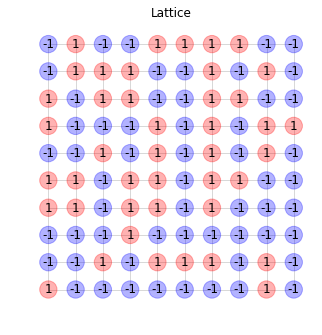

In [299]:
ising.draw_graph()

## Allow the user to change the bias toward +1 spin

In [301]:
ising.animate()

interactive(children=(FloatSlider(value=0.505, description='p', max=1.0, min=0.01), Output()), _dom_classes=('…

## Allow user to change the temperature

In [302]:
ising.runIsing()

interactive(children=(FloatSlider(value=5.0, description='temp', max=10.0), Output()), _dom_classes=('widget-i…